# 2015-11-10 lognote

## ToDo
- RHEA 量産
    - RHEA 発注。KEK 5 枚、ICRR 2 枚（見積りを早戸さんにパス）
    
- かもめデバッグ
    - 1 回目と 2 回目の間に待ち時間をいれてみる
    - 周波数の設定を 1 byte のループでの実装に変更してみる

### かもめデバッグ

1 回目の設定後に 0.1 sec の待ち時間を入れた場合。0.1 MHz 間隔。

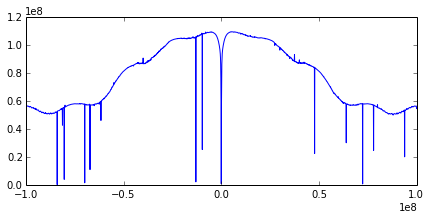

In [23]:
def foo():
    sd = read_sweep('/home/hikaru/readout/data/sweep_20151102_103053.csv')    
    fig, ax = plt.subplots(figsize=(7, 3))
    ax.plot(sd.freq, sd.amp)
    
foo()

1 回目の設定後に 1 sec の待ち時間を入れた場合。1 MHz 間隔。

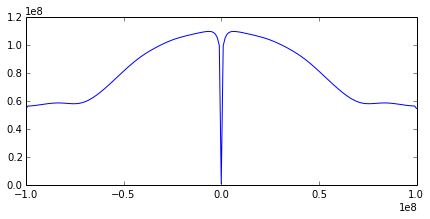

In [24]:
def foo():
    sd = read_sweep('/home/hikaru/readout/data/sweep_20151102_104725.csv')
    fig, ax = plt.subplots(figsize=(7, 3))
    ax.plot(sd.freq, sd.amp)
    
foo()

1 回目の設定後に 1 sec の待ち時間を入れた場合。0.1 MHz 間隔。

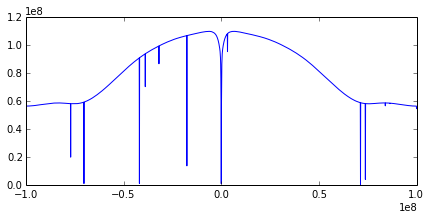

In [26]:
def foo():
    sd = read_sweep('/home/hikaru/readout/data/sweep_20151102_105312.csv')
    fig, ax = plt.subplots(figsize=(7, 3))
    ax.plot(sd.freq, sd.amp)
    
foo()

1 回目の設定後に 1 sec の待ち時間を入れた場合。0.01 MHz 間隔。

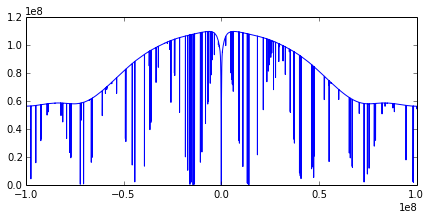

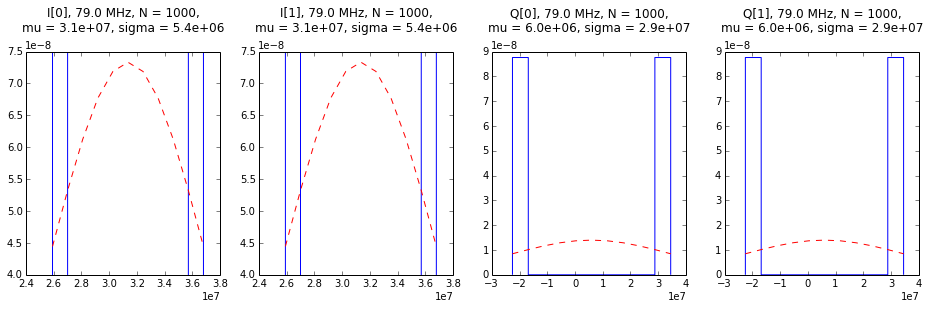

In [110]:
def foo():
    sd = read_sweep('/home/hikaru/readout/data/sweep_20151102_113904.csv')
    fig, ax = plt.subplots(figsize=(7, 3))
    ax.plot(sd.freq, sd.amp)

    ind = np.where(sd.freq == 79e6)[0][0]
    hist_iq(sd[ind:ind+1])

foo()

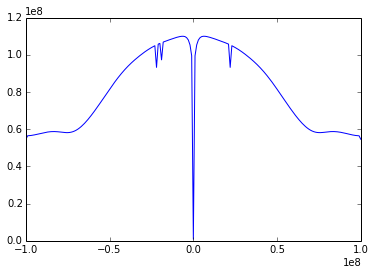

In [121]:
def foo():
    sd = read_sweep('/home/hikaru/readout/data/sweep_20151106_085947.csv')
    fig, ax = plt.subplots()
    ax.plot(sd.freq, sd.amp)
    
foo()

---
library

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

### dev 取得データを扱うクラス
sweep.py でとったデータを扱うクラス（SweepData）と csv データを read する関数（read_sweep）

In [116]:
class SweepDataError(Exception):
    def __init_(self, msg):
        self.msg = 'SweepData Error: %s' % str(msg)
        
    def __str__(self):
        return self.msg
        
class SweepData(object):
    def __init__(self, freq, i, q, i_raw=None, q_raw=None):
        self.freq  = np.array(freq)
        self.i     = np.array(i)
        self.q     = np.array(q)
        self.i_raw = np.array(i_raw) if i_raw is not None else None
        self.q_raw = np.array(q_raw) if q_raw is not None else None
        if self.i_raw is not None:
            self.ch     = len(self.i_raw)
            self.sample = len(self.i_raw[0][0])
        
    def __getitem__(self, key):
#         if isinstance(key, dict):
#             if key.keys()[0] in ['f', 'freq', 'frequency']:
#                 if key.values()[0] in self.freq:
#                     ind = np.where(self.freq == key.values()[0])[0][0]
#                     key = slice(ind, ind+1)
#                 else:
#                     raise ValueError('Specifyed frequency was not found.')
#             else:
#                 raise ValueError("key item must be ['f', 'freq', 'frequency'].")
        if not isinstance(key, slice):
            raise ValueError('SweepData.__getitem__ does not suppots it.')
            
        if self.i_raw is None:
            return SweepData(self.freq[key], self.i[key], self.q[key])
        else:
            return SweepData(self.freq[key], self.i[key], self.q[key],
                            [self.i_raw[c][key] for c in range(self.ch)],
                            [self.q_raw[c][key] for c in range(self.ch)])
    
    def __len__(self):
        return len(self.freq)

    @property
    def amp(self):
        return np.abs(self.i + 1j* self.q)
    
def read_sweep(fname, nchan=2, skiprows=10, skipfooter=None, comment='#', delimiter=','):
    with open(fname, 'r') as f:
        lines = f.readlines()

    if skipfooter is not None:
        lines = lines[skiprows:-skipfooter]
    else:
        lines = lines[skiprows:]
        
    d_unit = len(lines[0].split(delimiter)) # this value is 3 if -r option is not set
    
    freq  = []
    i     = []
    q     = []
    i_raw = [list() for k in range(nchan)] if d_unit > 3 else None
    q_raw = [list() for k in range(nchan)] if d_unit > 3 else None
    for line in lines:
        if line[0] == comment: continue
        l = [float(x) for x in line.split(delimiter)]
        freq.append(l[0])
        i.append(l[1])
        q.append(l[2])
        if i_raw is None: continue
        sample = (len(l) - 3) / (nchan*2)
        for ch in range(nchan):
            i_raw[ch].append(l[       ch *sample+3 :       (ch+1)*sample+3])
            q_raw[ch].append(l[(nchan+ch)*sample+3 : (nchan+ch+1)*sample+3])

    if i_raw is None:
        return SweepData(freq, i, q)
    else:
        return SweepData(freq, i, q, i_raw, q_raw)

sd = read_sweep('/home/hikaru/readout/data/sweep_20151030_094910.csv')

In [102]:
def hist_iq(SweepData, histtype='step'):
    nrows = len(SweepData)
    fig, ax = plt.subplots(ncols=4, nrows=nrows, figsize=(16, nrows*4))
    if nrows == 1: ax = np.array([ax])
    for j in range(nrows):
        n0, bins0, patches0 = ax[j][0].hist(SweepData.i_raw[0][j], normed=True, bins=np.log2(SweepData.sample)+1, histtype=histtype)
        n1, bins1, patches1 = ax[j][1].hist(SweepData.i_raw[1][j], normed=True, bins=np.log2(SweepData.sample)+1, histtype=histtype)
        n2, bins2, patches2 = ax[j][2].hist(SweepData.q_raw[0][j], normed=True, bins=np.log2(SweepData.sample)+1, histtype=histtype)
        n3, bins3, patches3 = ax[j][3].hist(SweepData.q_raw[1][j], normed=True, bins=np.log2(SweepData.sample)+1, histtype=histtype)
        # fit
        mu0, sigma0 = norm.fit(SweepData.i_raw[0][j])
        mu1, sigma1 = norm.fit(SweepData.i_raw[1][j])
        mu2, sigma2 = norm.fit(SweepData.q_raw[0][j])
        mu3, sigma3 = norm.fit(SweepData.q_raw[1][j])
        y0 = norm.pdf(bins0, mu0, sigma0)
        y1 = norm.pdf(bins1, mu1, sigma1)
        y2 = norm.pdf(bins2, mu2, sigma2)
        y3 = norm.pdf(bins3, mu3, sigma3)
        ax[j][0].plot(bins0, y0, 'r--')
        ax[j][1].plot(bins1, y1, 'r--')
        ax[j][2].plot(bins2, y2, 'r--')
        ax[j][3].plot(bins3, y3, 'r--')
        ax[j][0].set_title('I[0], %.1f MHz, N = %d,\nmu = %.1e, sigma = %.1e\n' % (SweepData.freq[j]/1e6, len(SweepData.i_raw[0][j]), mu0, sigma0))
        ax[j][1].set_title('I[1], %.1f MHz, N = %d,\nmu = %.1e, sigma = %.1e\n' % (SweepData.freq[j]/1e6, len(SweepData.i_raw[1][j]), mu1, sigma1))
        ax[j][2].set_title('Q[0], %.1f MHz, N = %d,\nmu = %.1e, sigma = %.1e\n' % (SweepData.freq[j]/1e6, len(SweepData.q_raw[0][j]), mu2, sigma2))
        ax[j][3].set_title('Q[1], %.1f MHz, N = %d,\nmu = %.1e, sigma = %.1e\n' % (SweepData.freq[j]/1e6, len(SweepData.q_raw[1][j]), mu3, sigma3))
        fig.subplots_adjust(hspace=0.72)
        for k in range(4):
            ax[j][k].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))

# hist_iq(read_sweep('/home/hikaru/airPupa/sweep_20151014_130453.csv'))

In [109]:
def foo():
    sd = read_sweep('/home/hikaru/readout/data/sweep_20151102_113904.csv')
    freq_ind = np.where(sd.freq == 8e6)[0][0]
    print freq_ind
    print sd[freq_ind:freq_ind+1]
#     print sd.i_raw[freq_ind]
    
foo()

10800


In [46]:
def foo():
    def bar(key):
        if isinstance(key, int):
            key = slice(2, 3)
        else:
            key = slice(1, 8)
        return range(10)[key]
    
    print bar(10)

foo()

[2]


In [93]:
def foo():
    def bar(arg, **kwargs):
        print arg
        print kwargs
        
    bar('test')
    bar('test':1e6)
    
foo()

SyntaxError: keyword can't be an expression (<ipython-input-93-20e389f69e74>, line 7)